#### Imports

In [1]:
import cv2
import tensorflow as tf      # Deep Learning library
import numpy as np           # Handle matrices

import random                # Handling random number generation
import time                  # Handling time calculation
from skimage import transform# Help us to preprocess the frames

from collections import deque # Ordered collection with ends
import matplotlib.pyplot as plt # Display graphs
%matplotlib inline


In [2]:
import gym

#### Playing with the environment

In [3]:
env = gym.make('Assault-v0')

In [4]:
print("Observation space: {}".format(env.observation_space)) # No. of possible board states
print("Num Action space: {}".format(env.action_space.n))      # No. of possible actions

Observation space: Box(250, 160, 3)
Num Action space: 7


In [5]:
# Comment for Colab
env.render()
env.close()

In [6]:
env.reset()
for _ in range(1000):
    obs, reward, done, info = env.step(env.action_space.sample())
    # Comment for Colab
    env.render()
env.close()

In [7]:
x = env.action_space.sample()
print(x)
print(env.action_space.contains(6))

1
True


#### 1. Preprocessing

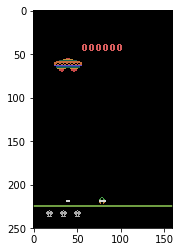

In [8]:
frame = env.reset()
plt.imshow(frame)

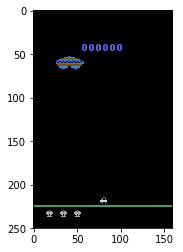

In [ ]:
# Collection observation frame for pre-processing test
env.reset()
obs, reward, done, info = env.step(env.action_space.sample())
env.close()

plt.imshow(cv2.cvtColor(obs, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
def preprocessing(obs):
    bw_frame = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    frame = bw_frame[50:224, :]
    normalized_frame = frame/255.0
    preprocessed_frame = transform.resize(normalized_frame, [84,84])
    return preprocessed_frame

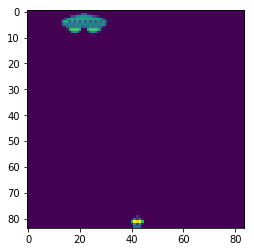

In [ ]:
plt.imshow(preprocessing(obs))
plt.show()

#### Part 2: Stacking Frames

In [ ]:
stack_size = 4
stacked_frames= deque([np.zeros((84, 84), dtype = np.int) for i in range(stack_size)], maxlen = 4)

def stack_frames(stacked_frames, state, is_new_episode):
    frame = preprocessing(state)
    if is_new_episode:
        # Reinitialize with 4 repeated frames
        for _ in range(4):
            stacked_frames.append(frame)
    else:
        # Just append the new frame(The last frame will get removed)
        stacked_frames.append(frame)
    
    # Converting Frames Deque to numpy.stack
    stacked_state = np.stack(stacked_frames, axis = 2)
    return stacked_state, stacked_frames

#### Part 3: Set Hyper-Parameters

In [ ]:
state_size = [84,84,4]      # Our input is a stack of 4 frames hence 84x84x4 (Width, height, channels) 
action_size = env.action_space.n
learning_rate =  0.0002      # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 500        # Total episodes for training
max_steps = 10000              # Max possible steps in an episode
batch_size = 64             

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.95               # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000          # Number of experiences the Memory can keep

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE (already)TRAINED AGENT
training = True

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = True

#### Part 4: Create the Tensorflow graph

In [ ]:
# Using a class DQNet for this
class DQNet:
    def __init__(self, state_size, action_size, learning_rate, name = 'DQNet'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        # Creating Placeholders for TF-graph
        with tf.variable_scope(name):
            self.inputs = tf.placeholder(tf.float32, [None, *state_size], name = "inputs")
            self.actions = tf.placeholder(tf.float32, [None, self.action_size], name = "actions")
            self.target_Q = tf.placeholder(tf.float32, [None], name = "target")
            
            # Creating the graph
            # 1
            self.conv1 = tf.layers.conv2d(inputs = self.inputs, filters = 32, kernel_size = [8,8], strides = [4,4], padding = "VALID", kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(), name = "conv1")
            self.conv1_batchnorm = tf.layers.batch_normalization(self.conv1, training = True, epsilon = 1e-5, name = "batch_norm")
            self.conv1_out = tf.nn.elu(self.conv1_batchnorm, name="conv1_out")
            
            # 2
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out, filters = 64, kernel_size = [4,4], strides = [2,2], padding = "VALID", kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(), name = "conv2")
            self.conv2_batchnorm = tf.layers.batch_normalization(self.conv2, training = True, epsilon = 1e-5, name = 'batch_norm2')
            self.conv2_out = tf.nn.elu(self.conv2_batchnorm, name="conv2_out")
            
            # 3
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out, filters = 128, kernel_size = [4,4], strides = [2,2], padding = "VALID", kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(), name = "conv3")
            self.conv3_batchnorm = tf.layers.batch_normalization(self.conv3, training = True, epsilon = 1e-5, name = 'batch_norm3')
            self.conv3_out = tf.nn.elu(self.conv3_batchnorm, name="conv3_out")
            
            # Fully-Connected
            self.flatten = tf.layers.flatten(self.conv3_out)
            self.fc = tf.layers.dense(inputs = self.flatten, units = 512, activation = tf.nn.elu, kernel_initializer=tf.contrib.layers.xavier_initializer(), name="fc1")
            self.output = tf.layers.dense(inputs = self.fc, units = 7, activation = None, kernel_initializer=tf.contrib.layers.xavier_initializer(), name="fc2")
            
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions), axis=1)
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)

In [ ]:
# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNet = DQNet(state_size, action_size, learning_rate)

W1222 21:57:16.559853 140647279589120 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1222 21:57:16.561385 140647279589120 deprecation.py:323] From <ipython-input-15-88ed69d8faf0>:16: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W1222 21:57:17.050407 140647279589120 deprecation.py:323] From <ipython-input-15-88ed69d8faf0>:17: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular

#### Experience Replay

In [ ]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)
        
        return [self.buffer[i] for i in index]

In [ ]:
# Instantiate Memory
memory = Memory(max_size = memory_size)

# Render new environment
state = env.reset()
for i in range(pretrain_length):
    # First Step
    if i==0:
        # Obtain Stacked States
        stacked_state, stacked_frames = stack_frames(stacked_frames, state, True)
        
    # Random Action
    action = env.action_space.sample()
    action_state = np.zeros(7)
    action_state[action] = 1

    # Take action and observe reward
    obs, reward, done, info = env.step(action)
    # If episode finished
    if done:
        # If episode is finished, next state is zero-array
        next_stacked_state = np.zeros(stacked_state.shape)
        # Add experience to memory
        memory.add((stacked_state, action_state, reward, next_stacked_state, done))
        # Update stacked state
        state = env.reset()
        stacked_state, stacked_frames = stack_frames(stacked_frames, state, True)
        
    else:
        next_stacked_state, stacked_frames = stack_frames(stacked_frames, obs, False)
        # Add experience to memory
        memory.add((stacked_state, action_state, reward, next_stacked_state, done))
        # Update stacked state
        stacked_state = next_stacked_state

In [ ]:
writer = tf.summary.FileWriter("tensorboard/dqn/1")

# Losses
tf.summary.scalar("Loss", DQNet.loss)
write_op = tf.summary.merge_all()

#### Choosing Action using an epsilon-greedy strategy

In [ ]:
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()

    # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
    
    if (explore_probability > exp_exp_tradeoff):
        # Make a random action (exploration)
        action = env.action_space.sample()
        
    else:
        # Get action from Q-network (exploitation)
        # Estimate the Qs values state
        Qs = sess.run(DQNet.output, feed_dict = {DQNet.inputs: state.reshape((1, *state.shape))})
        
        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)
        action = choice
        
    return action, explore_probability

In [ ]:
print(memory.sample(10))

[(array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 

#### Model Training

In [ ]:
# Saver will help us to save our model
saver = tf.train.Saver()

if training == True:
    with tf.Session() as sess:
        # Initialize all variables
        sess.run(tf.global_variables_initializer())
        
        # Decay step initialize for epsilon-greedy
        decay_step = 0
        env.reset()
        
        for episode in range(total_episodes):
            # print("new_episode.................................................")
            step = 0
            
            #Initialising Episode rewards
            episode_rewards = []
            
            # New Episode
            state = env.reset()
            
            # Stack frames
            stacked_state, stacked_frames = stack_frames(stacked_frames, state, True)
            
            while step < max_steps:
                step += 1
                # print(step)
                decay_step += 1
                
                action, explore_probability = predict_action(explore_start, explore_stop, decay_rate, decay_step, stacked_state)
                
                
                # Take action and observe reward
                obs, reward, done, info = env.step(action)
                
                # Add the reward to total reward
                episode_rewards.append(reward)
                # If the game is finished
                # print(done)
                if done:
                    # print("1")
                    # the episode ends so no next state
                    next_state = np.zeros(obs.shape, dtype=np.uint16)
                    
                    # Obtain stacked state
                    next_stacked_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

                    # Get the Total Rewards
                    total_reward = np.sum(episode_rewards)
                    print('Episode: {}'.format(episode), 'Total reward: {}'.format(total_reward), 'Training loss: {:.4f}'.format(loss),'Explore P: {:.4f}'.format(explore_probability))
                
                    action_state = np.zeros(7)
                    action_state[action] = 1
                    
                    # Add to memory
                    memory.add((stacked_state, action_state, reward, next_stacked_state, done))
                    step = max_steps
                    
                else:
                    # print("2")
                    # Get the next state
                    next_state = obs
                    
                    # Obtain Stacked next state
                    next_stacked_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                    
                    # Add experience to memory
                    memory.add((stacked_state, action_state, reward, next_stacked_state, done))
                
                    # Update state
                    stacked_state = next_stacked_state
                    
                ### LEARNING PART            
                # Obtain random mini-batch from memory
                batch = memory.sample(batch_size)
                states_mb = np.array([each[0] for each in batch], ndmin=3)
                actions_mb = np.array([each[1] for each in batch])
                rewards_mb = np.array([each[2] for each in batch]) 
                next_states_mb = np.array([each[3] for each in batch], ndmin=3)
                dones_mb = np.array([each[4] for each in batch])

                target_Qs_batch = []

                 # Get Q values for next_state 
                Qs_next_state = sess.run(DQNet.output, feed_dict = {DQNet.inputs: next_states_mb})
                # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma*maxQ(s', a')
                for i in range(0, len(batch)):
                    terminal = dones_mb[i]

                    # If we are in a terminal state, only equals reward
                    if terminal:
                        target_Qs_batch.append(rewards_mb[i])
                        
                    else:
                        target = rewards_mb[i] + gamma * np.max(Qs_next_state[i])
                        target_Qs_batch.append(target)
                        

                targets_mb = np.array([each for each in target_Qs_batch])

                loss, _ = sess.run([DQNet.loss, DQNet.optimizer],
                                    feed_dict={DQNet.inputs: states_mb,
                                               DQNet.target_Q: targets_mb,
                                               DQNet.actions: actions_mb})

                # Write TF Summaries
                summary = sess.run(write_op, feed_dict={DQNet.inputs: states_mb,
                                                   DQNet.target_Q: targets_mb,
                                                   DQNet.actions: actions_mb})
                writer.add_summary(summary, episode)
                writer.flush()

            # Save model every 5 episodes
            if episode % 5 == 0:
                save_path = saver.save(sess, "./models/model.ckpt")
                print("Model Saved")
     
        

Episode: 0 Total reward: 126.0 Training loss: 1.6658 Explore P: 0.9670
Model Saved
Episode: 1 Total reward: 231.0 Training loss: 1.7730 Explore P: 0.9195
Episode: 2 Total reward: 336.0 Training loss: 2.4660 Explore P: 0.8494
Episode: 3 Total reward: 273.0 Training loss: 2.6623 Explore P: 0.7817
Episode: 4 Total reward: 210.0 Training loss: 4.8224 Explore P: 0.7229
